# Assignment 2: Image Generation Project
Submitted by: Rishabh Kaushick

# 1. Environment Setup (5%)
- Install the necessary libraries (e.g., TensorFlow or PyTorch, NumPy, Matplotlib).
- Verify that the CIFAR-10 dataset can be successfully loaded using your chosen framework.
- Document your environment setup (e.g., software versions, hardware used).

In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
# import torchvision.datasets as dset
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import seaborn as sns

## Checking That CUDA (GPU) Is Available To Use

In [2]:
 
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available: {torch.cuda.is_available()}")
 
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"cuDNN enabled: {torch.backends.cudnn.enabled}")
    print(f"GPU Count: {torch.cuda.device_count()}")
    
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB")
        print(f"Memory Reserved: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB")
 
else:
    print("CUDA is not available. Running on CPU.")

PyTorch version: 2.2.1+cu121
Is CUDA available: True
CUDA version: 12.1
cuDNN version: 8902
cuDNN enabled: True
GPU Count: 1
GPU 0: NVIDIA L4
Memory Allocated: 0.00 MB
Memory Reserved: 0.00 MB


In [3]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("GPU can be enabled through MPS (for MacOS).")


MPS not available because the current PyTorch install was not built with MPS enabled.


## Loading The Dataset

I have downloaded the dataset from Kaggle: https://www.kaggle.com/datasets/pankrzysiu/cifar10-python/code

Based on the README of the dataset, the authors provided snippets of the function that can be used to load the pickled dataset from the provided files:

In [4]:
# following the function provided by the authors of the CIFAR-10 dataset
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
train_batch1_dict = unpickle('./data/cifar-10-batches-py/data_batch_1')

In [6]:
train_batch1_dict.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [7]:
train_batch1_dict[b'data'][0:10]

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 28,  30,  33, ..., 100,  99,  96],
       [134, 131, 128, ..., 136, 137, 138],
       [125, 110, 102, ...,  82,  84,  86]], dtype=uint8)

In [8]:
train_batch1_dict[b'labels'][0:10]

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]

In [9]:
train_batch1_dict[b'filenames'][0:10]

[b'leptodactylus_pentadactylus_s_000004.png',
 b'camion_s_000148.png',
 b'tipper_truck_s_001250.png',
 b'american_elk_s_001521.png',
 b'station_wagon_s_000293.png',
 b'coupe_s_001735.png',
 b'cassowary_s_001300.png',
 b'cow_pony_s_001168.png',
 b'sea_boat_s_001584.png',
 b'tabby_s_001355.png']

In [10]:
len(train_batch1_dict[b'data'])

10000

In [11]:
len(train_batch1_dict[b'labels'])

10000

Now that we know what the data looks like, let's extract the remaining batches of the training data.

In [12]:
def load_cifar10_train_data():
    all_data = []
    all_labels = []
    all_filenames = []
    
    for batch_id in range(1, 6):
        batch_path = f'./data/cifar-10-batches-py/data_batch_{batch_id}'
        batch_dict = unpickle(batch_path)
        
        # Extract and append data
        all_data.append(batch_dict[b'data'])
        all_labels.extend(batch_dict[b'labels'])
        # all_filenames.extend([fname.decode('utf-8') for fname in batch_dict[b'filenames']])
    
    # Combine all data batches
    combined_data = np.vstack(all_data)
    
    # Create DataFrame
    df = pd.DataFrame({
        # 'filename': all_filenames,
        'label': all_labels
    })
    
    # Add image data columns (reshape from 32x32x3 format)
    # CIFAR-10 images are stored as 3072 values (32x32x3)
    df['image_data'] = list(combined_data)
    
    return df

# Load the data
cifar10_train_df = load_cifar10_train_data()

# Display basic information about the dataset
print(f"Total number of training images: {len(cifar10_train_df)}")
print("\nFirst few rows of the DataFrame:")
print(cifar10_train_df.head())

Total number of training images: 50000

First few rows of the DataFrame:
   label                                         image_data
0      6  [59, 43, 50, 68, 98, 119, 139, 145, 149, 149, ...
1      9  [154, 126, 105, 102, 125, 155, 172, 180, 142, ...
2      9  [255, 253, 253, 253, 253, 253, 253, 253, 253, ...
3      4  [28, 37, 38, 42, 44, 40, 40, 24, 32, 43, 30, 3...
4      1  [170, 168, 177, 183, 181, 177, 181, 184, 189, ...


## Normalizing Inputs

In [13]:
# Root directory for dataset
# dataroot = "./data/cifar-10-batches-py"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 6

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [14]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## Creating Dataset & Data Loader

In [15]:
class CIFAR10Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transforms.Compose([
                                        transforms.Resize(image_size),
                                        transforms.CenterCrop(image_size),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                        ])

        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Get image data from DataFrame
        image_data = self.dataframe.iloc[idx]['image_data']
        label = self.dataframe.iloc[idx]['label']
        
        # Reshape the flat array back to CHW format
        image = image_data.reshape(3, 32, 32)

        # Convert to HWC format (32, 32, 3) for PIL
        image = image.transpose(1, 2, 0)

        # Ensure the data type is uint8 and in the correct range [0, 255]
        image = np.clip(image, 0, 255).astype(np.uint8)
        
        # Convert to PIL Image (required for torchvision transforms)
        image = Image.fromarray(image)
        
        # Apply transforms
        image_tensor = self.transform(image)
            
        return image_tensor, label

In [16]:
# Let's create a DataLoader for the CIFAR-10 dataset
def create_dataloader(dataframe, batch_size=128, shuffle=True, num_workers=2):
    # Create dataset
    dataset = CIFAR10Dataset(dataframe)
    
    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return dataloader

In [17]:
train_dataloader = create_dataloader(cifar10_train_df, batch_size=batch_size, num_workers=2)

# 2. Dataset Exploration (5%)

## Data Characteristics

In [18]:
cifar10_train_df['label'].unique()

array([6, 9, 4, 1, 2, 7, 8, 3, 5, 0])

### Class Distribution

In [19]:
cifar10_train_df['label'].value_counts()

label
6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
Name: count, dtype: int64

In [20]:
# Create a dictionary for each type of label 
# labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels = {0 : "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
          5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data["label"].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(cifar10_train_df)

frog                :   5000 or 10.0%
truck               :   5000 or 10.0%
deer                :   5000 or 10.0%
automobile          :   5000 or 10.0%
bird                :   5000 or 10.0%
horse               :   5000 or 10.0%
ship                :   5000 or 10.0%
cat                 :   5000 or 10.0%
dog                 :   5000 or 10.0%
airplane            :   5000 or 10.0%


/tmp/ipykernel_2008/1927707818.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.countplot(data=data, x='label',


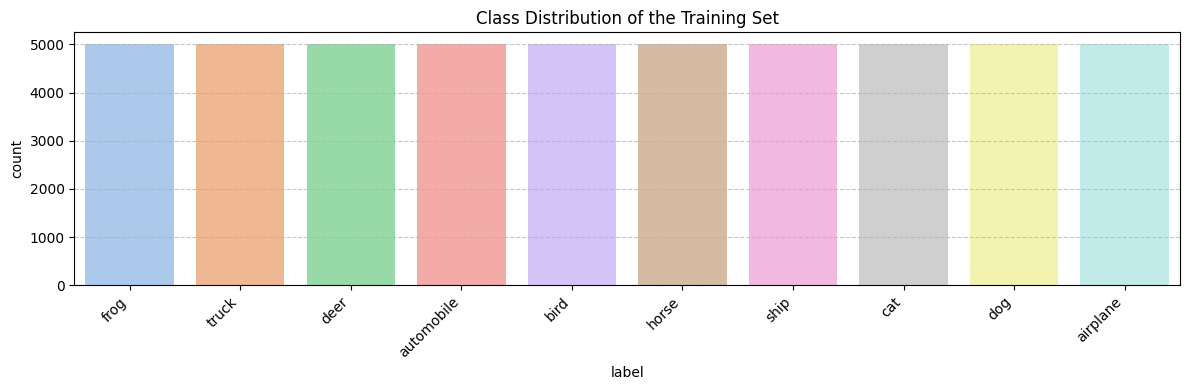

In [21]:
def plot_label_per_class(data, title):
    f, ax = plt.subplots(1,1, figsize=(12,4))
    # Use palette='Set2' for different colors, and map labels to their names for x-axis
    g = sns.countplot(data=data, x='label', 
                     order=data["label"].value_counts().index,
                     palette='pastel')
    g.set_title("Class Distribution of the "+title)
    
    # Replace x-axis numeric labels with the names of the clothing apparel
    plt.xticks(range(len(labels)), [labels[i] for i in data["label"].value_counts().index], rotation=45, ha='right')
    
    # adding lines on the y axis for better understanding of the data
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

plot_label_per_class(cifar10_train_df, 'Training Set')

## Displaying Images from CIFAR-10 Dataset

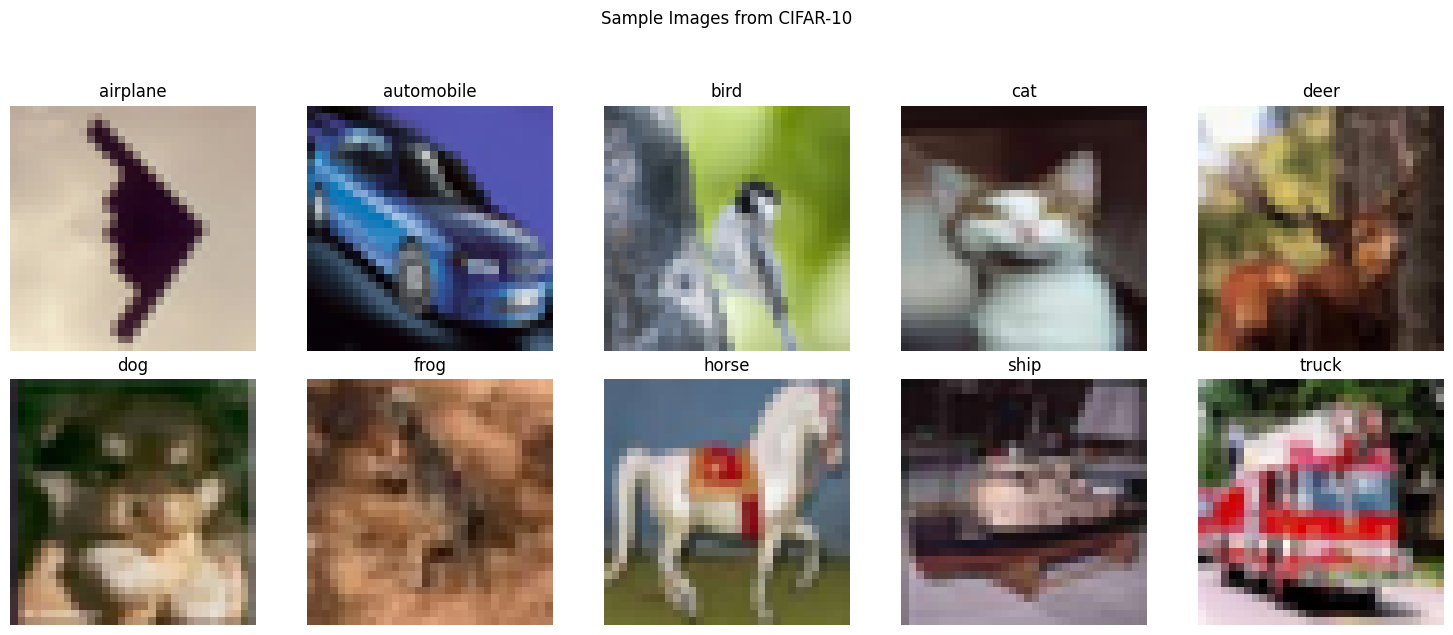

In [22]:
def plot_sample_images(df, labels_dict):
    # Set up the plot
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    # For each label (0-9)
    for idx, label_id in enumerate(sorted(labels_dict.keys())):
        # Get one random image from this class
        sample = df[df['label'] == label_id].sample(1).iloc[0]
        
        # Reshape the image data from 1D to 3D (32x32x3)
        # transpose is required since CIFAR-10 dataset images are store in a 
        # channel-first format, however, matplotlib expects it in a channel-last format.
        img = sample['image_data'].reshape(3, 32, 32).transpose(1, 2, 0)
        
        # Plot the image
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'{labels_dict[label_id]}')
    
    plt.suptitle('Sample Images from CIFAR-10', y=1.05)
    plt.tight_layout()
    plt.show()


# Plot the samples
plot_sample_images(cifar10_train_df, labels)

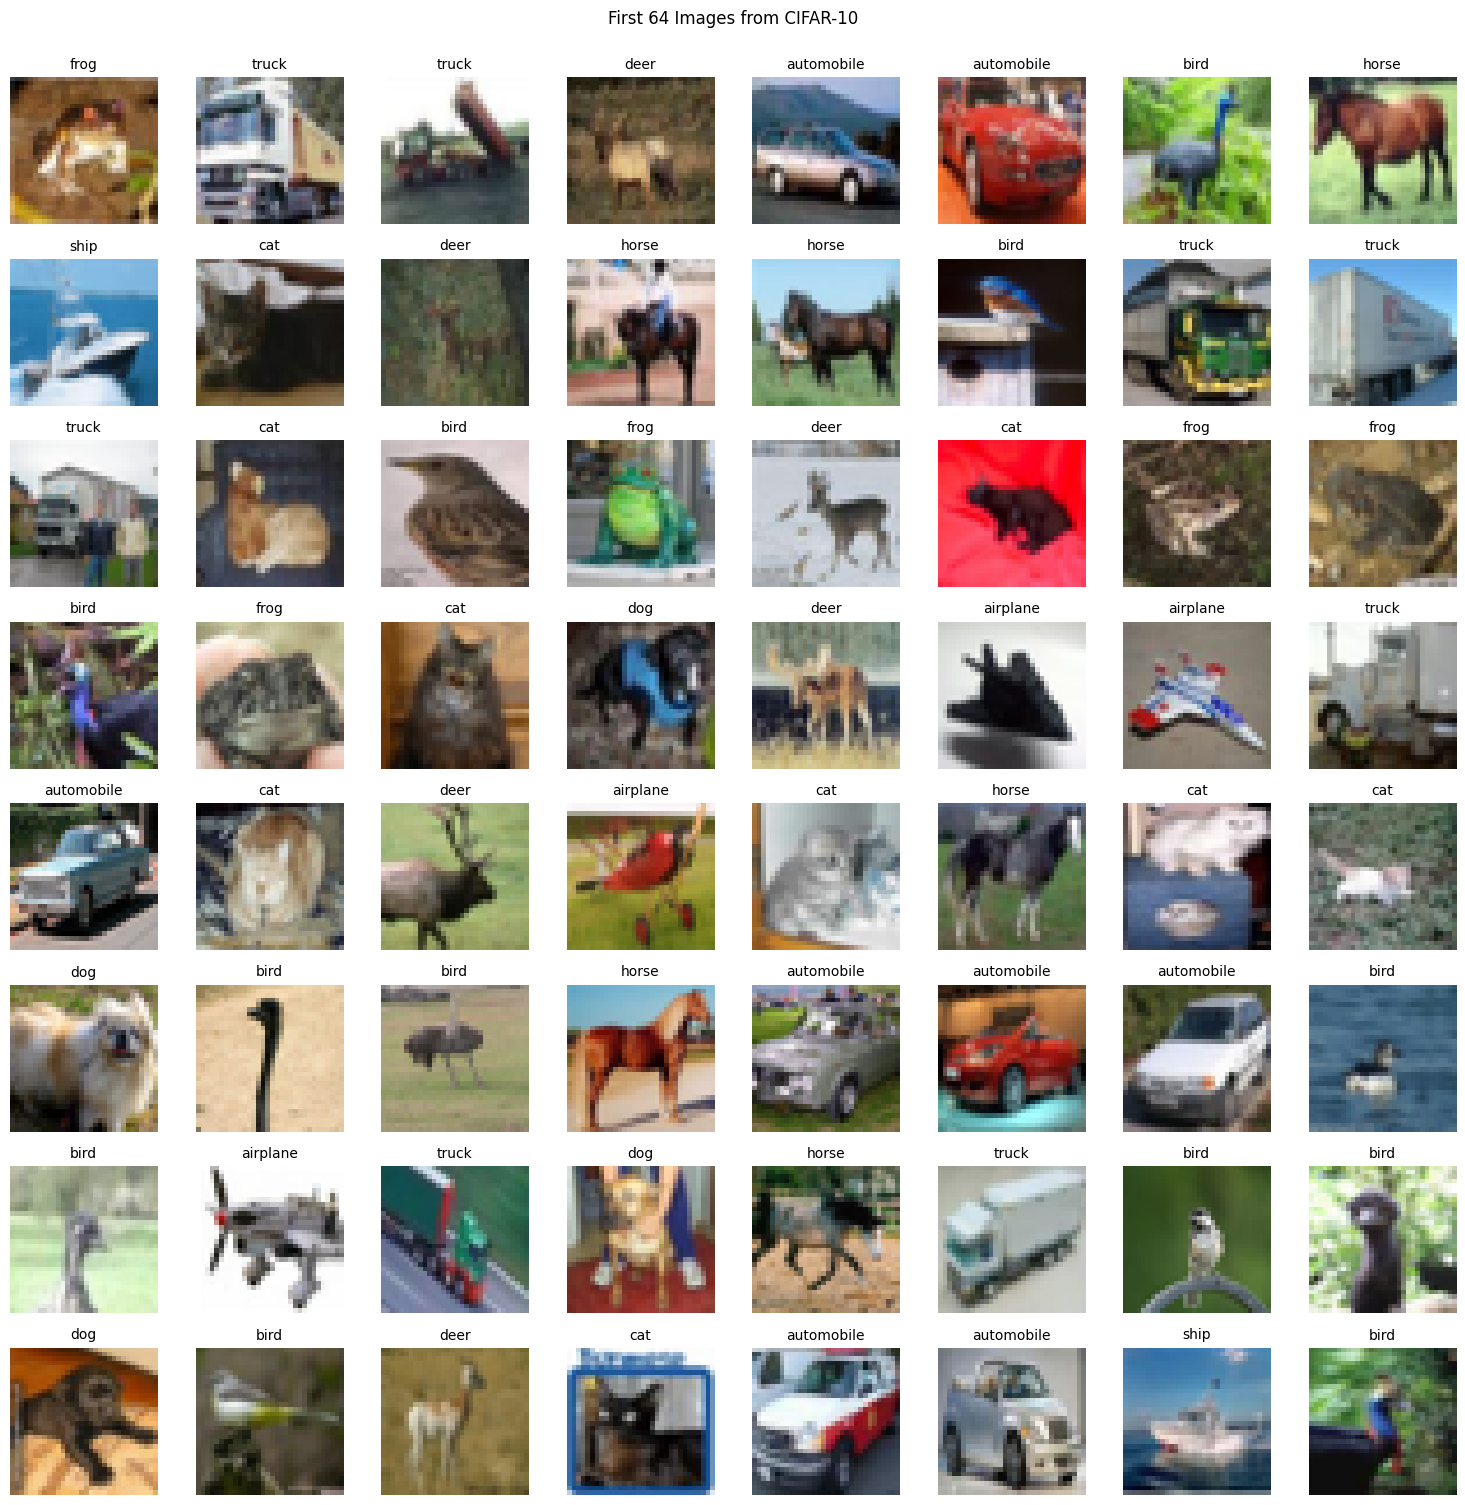

In [23]:
def plot_first_64_images(df, labels_dict):
    # Set up the plot
    fig, axes = plt.subplots(8, 8, figsize=(15, 15))
    axes = axes.ravel()  # Flatten the 2D array of axes
    
    # For the first 64 images
    for idx in range(64):
        # Get image and its label
        sample = df.iloc[idx]
        label = labels_dict[sample['label']]
        
        # Reshape the image data from 1D to 3D (32x32x3)
        img = sample['image_data'].reshape(3, 32, 32).transpose(1, 2, 0)
        
        # Plot the image
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(label, fontsize=10)
    
    plt.suptitle('First 64 Images from CIFAR-10', y=1.0)
    plt.tight_layout()
    plt.show()

# Plot the first 64 images
plot_first_64_images(cifar10_train_df, labels)

# 3. GAN Architecture Design (20%)

Generative adversarial networks belong to a category of unsupervised learning algorithms. In this architecture, there are two neural networks that compete in a minimax game. The first neural network is known as a generator, which tries to create images (initially out of random noise). The second part is the discriminator, which is trained to detect whether the input image received is real or fake. These two networks are pitted against each other through an adversarial process. Initially, the generator is very bad at creating images, and the discriminator can easily distinguish between real images and fake images that is created by the generator. However, the loss at the end of the discriminator is back-propagated to the generator, and now the generator can generate images that are more realistic. Finally at one point the generator will become so good, that the discriminator will be unable to tell with more than 50% certainty if an image is real or fake. At this point, the generator neural network can be removed from this architecture and be used for generating realistic images based on the training data.

## GAN Architecture

![](./visuals/gan_architecture.svg)

## GAN: Error Back-Propagation

![Discriminator back-propagation](./visuals/discriminator_backprop.svg)

![Generator back-propagation](./visuals/generator_backprop.svg)

## Building GAN Network

Before building the GAN, we must define inputs required to run the PyTorch model.

### Generator Neural Network

Let us begin by creating the generator neural network. I have decided to use the architecture as mentioned in the paper: Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks [3] (DCGANs) as shown in the figure below. DCGANs combine the characteristics of Convolutional Neural Networks (CNNs) and GANs. CNNs have seen success and wide adoption in applications of computer vision. 
The generator neural network architecture as seen below consists of the following components:
- Convolutional transpose layers
- Batch normalization layers
- ReLU activation function


![DCGAN generator architecture](./visuals/dcgan_generator.png)

In [24]:
# Generator Code (DC-GAN Architecture)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In the DCGAN paper, the authors mentioned that all the model weights would be randomly initialized from a normal distribution which has mean as 0 and standard deviation as 0.02, and for that reason I have decided to do the same.

In [25]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#### Instantiate Generator & Apply Custom Weights

In [26]:
# Create the generator
netG = Generator(ngpu).to(device)
# netG = Generator(ngpu).to(mps_device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Discriminator Neural Network

Discriminator network is a binary classifier trained to output whether an input image is real or fake. The discriminator neural network architecture is made up of the following components: 
- Stridden convolutional layers
- Batch normalization layers
- Leaky ReLU activations

As discussed above, the discriminator network must back-propagate the discriminator loss as well as the generator loss. In this case, leaky ReLU activations are used because they help the gradients easily back-propagate through the network.


In [27]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [28]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
# netD = Discriminator(ngpu).to(mps_device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### Loss Functions & Optimizers

For the initial model, I have decided to replicate the DCGAN paper and use the same Binary Cross Entropy loss function (BCELoss in PyTorch) and Adam optimizers.
For computing the loss at the end of the discriminator network, we must define our labels:
- 1: a real image
- 0: a fake image

There would be two optimizers, one for the generator network, and one for the discriminator network. In the DCGAN paper, they used the same parameters for both **Adam optimizers with learning rate as 0.0002 and Beta1 = 0.5.** 


In [29]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# 4. Training Process (25%)

![Graph showing how the GAN models get better](./visuals/gan_paper_graph.png)

Starting Training Loop...
[0/6][0/391]	Loss_D: 1.7048	Loss_G: 6.4176	D(x): 0.5295	D(G(z)): 0.5186 / 0.0029
[0/6][50/391]	Loss_D: 0.0554	Loss_G: 9.6353	D(x): 0.9587	D(G(z)): 0.0118 / 0.0002
[0/6][100/391]	Loss_D: 0.2465	Loss_G: 6.1047	D(x): 0.9013	D(G(z)): 0.1073 / 0.0064
[0/6][150/391]	Loss_D: 0.2559	Loss_G: 6.4929	D(x): 0.9212	D(G(z)): 0.1467 / 0.0021
[0/6][200/391]	Loss_D: 0.2836	Loss_G: 4.1806	D(x): 0.8929	D(G(z)): 0.1361 / 0.0224
[0/6][250/391]	Loss_D: 0.0802	Loss_G: 8.5300	D(x): 0.9378	D(G(z)): 0.0067 / 0.0005
[0/6][300/391]	Loss_D: 0.6269	Loss_G: 3.8509	D(x): 0.9166	D(G(z)): 0.3435 / 0.0436
[0/6][350/391]	Loss_D: 1.2511	Loss_G: 2.1064	D(x): 0.4361	D(G(z)): 0.0084 / 0.2587
[1/6][0/391]	Loss_D: 0.4020	Loss_G: 4.1290	D(x): 0.9339	D(G(z)): 0.2553 / 0.0228
[1/6][50/391]	Loss_D: 0.3873	Loss_G: 3.0556	D(x): 0.7401	D(G(z)): 0.0288 / 0.0718
[1/6][100/391]	Loss_D: 0.4564	Loss_G: 1.1187	D(x): 0.7000	D(G(z)): 0.0363 / 0.3692
[1/6][150/391]	Loss_D: 0.4319	Loss_G: 4.0699	D(x): 0.8232	D(G(z)): 

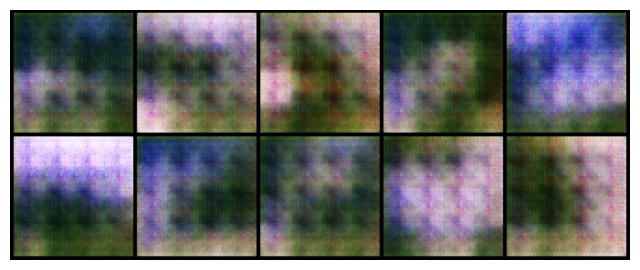

[2/6][0/391]	Loss_D: 0.8628	Loss_G: 2.1268	D(x): 0.5859	D(G(z)): 0.1101 / 0.1758
[2/6][50/391]	Loss_D: 0.4641	Loss_G: 2.5783	D(x): 0.7453	D(G(z)): 0.1019 / 0.0992
[2/6][100/391]	Loss_D: 1.1284	Loss_G: 2.3109	D(x): 0.4327	D(G(z)): 0.0290 / 0.1370
[2/6][150/391]	Loss_D: 0.6466	Loss_G: 4.2386	D(x): 0.8359	D(G(z)): 0.3165 / 0.0220
[2/6][200/391]	Loss_D: 0.6190	Loss_G: 4.7841	D(x): 0.8868	D(G(z)): 0.3481 / 0.0135
[2/6][250/391]	Loss_D: 0.4637	Loss_G: 5.3387	D(x): 0.9717	D(G(z)): 0.3047 / 0.0077
[2/6][300/391]	Loss_D: 0.5135	Loss_G: 4.2411	D(x): 0.8972	D(G(z)): 0.2897 / 0.0243
[2/6][350/391]	Loss_D: 0.2872	Loss_G: 3.3492	D(x): 0.8561	D(G(z)): 0.1043 / 0.0526
[3/6][0/391]	Loss_D: 0.7703	Loss_G: 3.3367	D(x): 0.6075	D(G(z)): 0.0455 / 0.0839
[3/6][50/391]	Loss_D: 0.5572	Loss_G: 4.9213	D(x): 0.9292	D(G(z)): 0.3413 / 0.0114
[3/6][100/391]	Loss_D: 0.4602	Loss_G: 3.6597	D(x): 0.8165	D(G(z)): 0.1894 / 0.0399
[3/6][150/391]	Loss_D: 0.7018	Loss_G: 3.6039	D(x): 0.7709	D(G(z)): 0.2829 / 0.0479
[3/6][200/

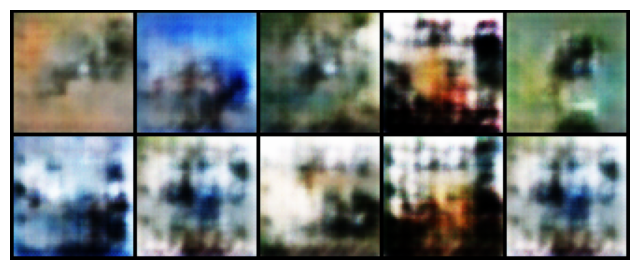

[4/6][0/391]	Loss_D: 0.7145	Loss_G: 3.8317	D(x): 0.8128	D(G(z)): 0.3331 / 0.0345
[4/6][50/391]	Loss_D: 0.6478	Loss_G: 2.1760	D(x): 0.6565	D(G(z)): 0.1101 / 0.1603
[4/6][100/391]	Loss_D: 0.5131	Loss_G: 3.5891	D(x): 0.8298	D(G(z)): 0.2435 / 0.0408
[4/6][150/391]	Loss_D: 0.5827	Loss_G: 3.7775	D(x): 0.8347	D(G(z)): 0.2838 / 0.0350
[4/6][200/391]	Loss_D: 0.4312	Loss_G: 3.3542	D(x): 0.8300	D(G(z)): 0.1905 / 0.0482
[4/6][250/391]	Loss_D: 0.3812	Loss_G: 2.7817	D(x): 0.8250	D(G(z)): 0.1541 / 0.0791
[4/6][300/391]	Loss_D: 1.0665	Loss_G: 5.3064	D(x): 0.8922	D(G(z)): 0.5374 / 0.0093
[4/6][350/391]	Loss_D: 0.9589	Loss_G: 3.3003	D(x): 0.7683	D(G(z)): 0.4527 / 0.0493
[5/6][0/391]	Loss_D: 1.7732	Loss_G: 8.4611	D(x): 0.9495	D(G(z)): 0.7506 / 0.0004
[5/6][50/391]	Loss_D: 0.4719	Loss_G: 2.8748	D(x): 0.7011	D(G(z)): 0.0617 / 0.0789
[5/6][100/391]	Loss_D: 0.9464	Loss_G: 2.1618	D(x): 0.5119	D(G(z)): 0.1074 / 0.1608
[5/6][150/391]	Loss_D: 0.8968	Loss_G: 5.7410	D(x): 0.8977	D(G(z)): 0.4906 / 0.0061
[5/6][200/

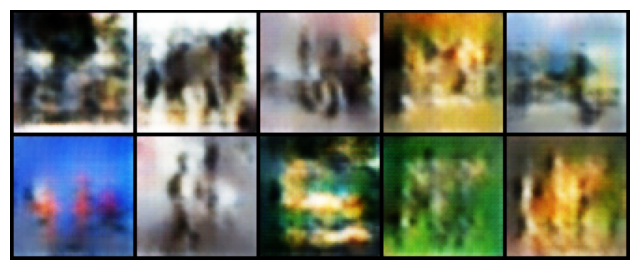

In [30]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the train_dataloader
    for i, data in enumerate(train_dataloader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake_display = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_display, padding=2, normalize=True))

        iters += 1

    # for every 2 epochs let's display how the images created by the generator (fake images)
    if ((epoch+1)%2==0):
                    
        plt.figure(figsize=(8,8))
        plt.axis("off")
        pictures=vutils.make_grid(fake_display[torch.randint(len(fake_display), (10,))],nrow=5,padding=2, normalize=True)
        plt.imshow(np.transpose(pictures,(1,2,0)))
        plt.show()

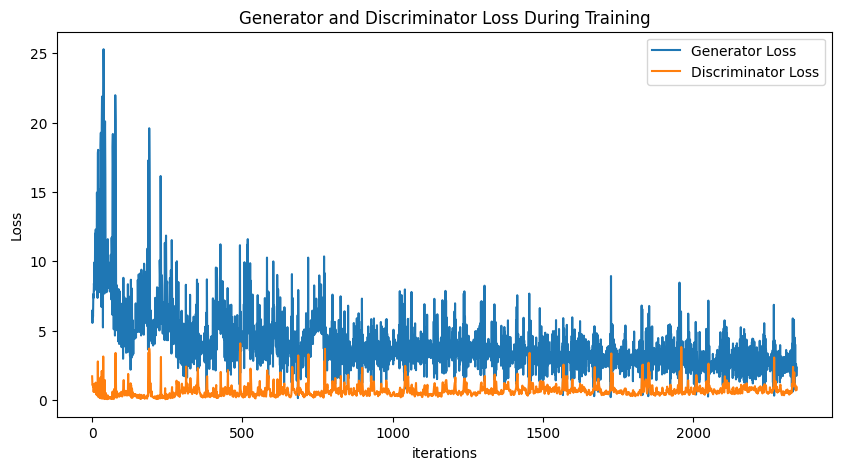

In [32]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator Loss")
plt.plot(D_losses,label="Discriminator Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


# 5. Model Evaluation and Results (20%)

# 6. Challenges and Solutions (10%)

# 7. Documentation and Presentation (15%)
- Write a clear, concise report covering:
    - Objective of the assignment.
    - Description of the GAN architecture.
    - Training process and results.
    - Challenges and solutions.
- Include visualizations (e.g., loss curves, generated images).

# 8. Bonus (Optional, 10%)

- Experiment with Variational Autoencoders (VAEs) on the CIFAR-10 dataset.
- Compare the performance of VAEs with GANs for image generation.
- Provide insights into their strengths and weaknesses.